# Auswirkungen von Überschriften auf den Aktienkurs
<br>
<b>In diesem Notebook wird versucht eine Beziehung zwischen Überschriften von Nachrichten über Aktien (Aktiennews) und den dazu gehörigen Aktienpreisen darzustellen und zu belegen.</b><br>
Dazu wird ein Datensatzes von bot_developer <a href="https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests">Daily Financial News for 6000+ Stocks, Kaggle</a> mit Headlines zu Stocks sowie die Aktienpreise, bezogen durch eine API von <a href="https://www.polygon.io">Polygon.io</a>, herangezogen.
<br><br>
<i>Im folgenden wird nach dem CRISP-DM vorgegangen.</i>
<br><br>
@author DHR <br>
@author BKN <br>
Stand: 17.08.2021

(Die Markdown-Zellen sind in deutscher Beschreibung, der Code sowie auch die Code-Kommentare sind auf Englisch verfasst.)

## Hinweise zur Abgabe
* Der API call ist nicht mehr lauffähig, der API-Key liegt diesem Notebook nicht bei. Der API call hat eine Laufzeit von über 10 Stunden.
* Der apply des 'publish_count' hat eine Laufzeit von ca. 30min (liegt jedoch schon als csv vor).
* Der Merge der TF-IDF Matrix mit dem Preparierten Datensatz läuft bei normalen Einstellung in einen Memory-Allocation-Error (ein Workaround hilft, um mehr RAM zur Verfügung zu stellen).

## Requirements
Zur Installation aller benötigten Module nutzen Sie<br>
<code>python -m pip install -r requirements.txt</code> (keine Garantie für Vollständigkeit)<br>
<i>Dieses Notebook läuft auf <b>Python 3.9.5 </b> <br> Es wird die verwendung eines virtuellen Enviroments empfohlen</i>

In [1]:
# basic Python Modules
import os
import sys
import random
import datetime
import time

# basic DataScience Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# basic Data Understanding
import statistics

# basic visualization for Data Understanding
from wordcloud import WordCloud

In [3]:
# headline cleaning
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

from sentistrength import PySentiStr
# from stanfordcorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP(r'G:\JavaLibraries\stanford-corenlp-full-2018-02-27')


[nltk_data] Downloading package wordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dominik Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [4]:
# api requirements
from polygon import RESTClient
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [5]:
# Sentiment Modelling, Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
# tf-idf Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [7]:
# load the Dataset as pandas DataFrame
"""
bot_developer, Daily Financial News for 6000+ Stocks; Kaggle: (https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests)
"""
data = pd.read_csv('../data/raw_analyst_ratings.csv')

## Data Understanding

Die Daten wurden bisher nicht von uns bereinigt.

### First Look

In [8]:
# first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


id                                           headline  \
100479    101291                  Benzinga's Top #PreMarket Gainers   
169629    170714  Goldman Sachs Maintains Blackrock at Neutral, ...   
92209      92998  Ark Restaurants Reports Temporary Closure Of C...   
1340418  1346780  Option Alert: Western Digital March 44 Call; B...   
723746    727489           UPDATE: Kirkland's Q4 Profit Meets Views   
1401320  1407831  Zions Bancorporation Reports Q4 EPS of $0.19 D...   
210045    211416  Can-Fite Biopharma +5% Premarket; H.C. Wainwri...   

                                                       url          publisher  \
100479   https://www.benzinga.com/news/15/12/6015278/be...      Monica Gerson   
169629   https://www.benzinga.com/analyst-ratings/price...          webmaster   
92209    https://www.benzinga.com/news/20/03/15573402/a...  Benzinga Newsdesk   
1340418  https://www.benzinga.com/markets/options/12/03...      Charles Gross   
723746   https://www.benzinga.com/news/earnings/15/03/5...      Monica Gerson   
1401320  https://www.benzinga.com/news/earnings/13/01/3...      Paul Quintaro   
210045   https://www.benzinga.com/analyst-ratings/analy...      Charles Gross   

                              date stock  
100479         2015-12-02 00:00:00  ASNA  
169629         2012-04-19 00:00:00   BLK  
92209    2020-03-17 16:30:42-04:00  ARKR  
1340418        2012-03-02 00:00:00   WDC  
723746         2015-03-12 00:00:00  KIRK  
1401320        2013-01-28 00:00:00  ZION  
210045         2015-11-30 00:00:00  CANF

In [9]:
# some statistics about the DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [10]:
# group by the stocks
stock = data.groupby("stock")
stock.sample()

id                                           headline  \
823          829  Zacks Analyst Blog Highlights: Wendy's/Arby's ...   
3129        3531        Jefferies Gives Buy Rating, $12 PT to Alcoa   
4225        4654  AAC Holdings, Inc. Common Stock Q3 EPS $(0.08)...   
4334        4763    As Global Stocks Rally, Don't Forget These ETFs   
4580        5020  'Airline mechanics feel pressured to overlook ...   
...          ...                                                ...   
1405513  1412034  UPDATE: Ancora Confident New Investor Base Wil...   
1405684  1412205  Stocks Which Set New 52-Week High Yesterday, O...   
1406245  1412766                         Benzinga's Top Initiations   
1407197  1413718  Piper Jaffray Raises Price Target on Gordmans ...   
1407295  1413816  China Zenix Auto Wins Supply Contract With Car...   

                                                       url  \
823      https://www.benzinga.com/10/11/615372/zacks-an...   
3129     https://www.benzinga.com/analyst-ratings/analy...   
4225     https://www.benzinga.com/news/earnings/18/11/1...   
4334     https://www.benzinga.com/trading-ideas/long-id...   
4580     https://www.benzinga.com/news/19/02/13093772/a...   
...                                                    ...   
1405513  https://www.benzinga.com/general/hedge-funds/1...   
1405684  https://www.benzinga.com/trading-ideas/technic...   
1406245  https://www.benzinga.com/analyst-ratings/initi...   
1407197  https://www.benzinga.com/analyst-ratings/analy...   
1407295  https://www.benzinga.com/news/15/01/5180386/ch...   

                    publisher                       date stock  
823                     Zacks        2010-11-16 00:00:00     A  
3129           Dwight Einhorn        2012-04-11 00:00:00    AA  
4225        Benzinga Newsdesk        2018-11-06 00:00:00   AAC  
4334            ETF Professor  2013-09-06 15:06:35-04:00  AADR  
4580        Benzinga_Newsdesk        2019-02-04 00:00:00   AAL  
...                       ...                        ...   ...  
1405513         Paul Quintaro        2015-12-30 00:00:00   ZTR  
1405684     Benzinga Newsdesk        2018-10-04 00:00:00   ZTS  
1406245            Lisa Levin        2014-10-17 00:00:00    ZU  
1407197  Michael J. Zerinskas        2010-12-01 00:00:00  ZUMZ  
1407295         Charles Gross        2015-01-27 00:00:00    ZX  

[6204 rows x 6 columns]

#### Range of Date

In [11]:
# Range of Date
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


In [12]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

Text(0, 0.5, 'Number of Healines')

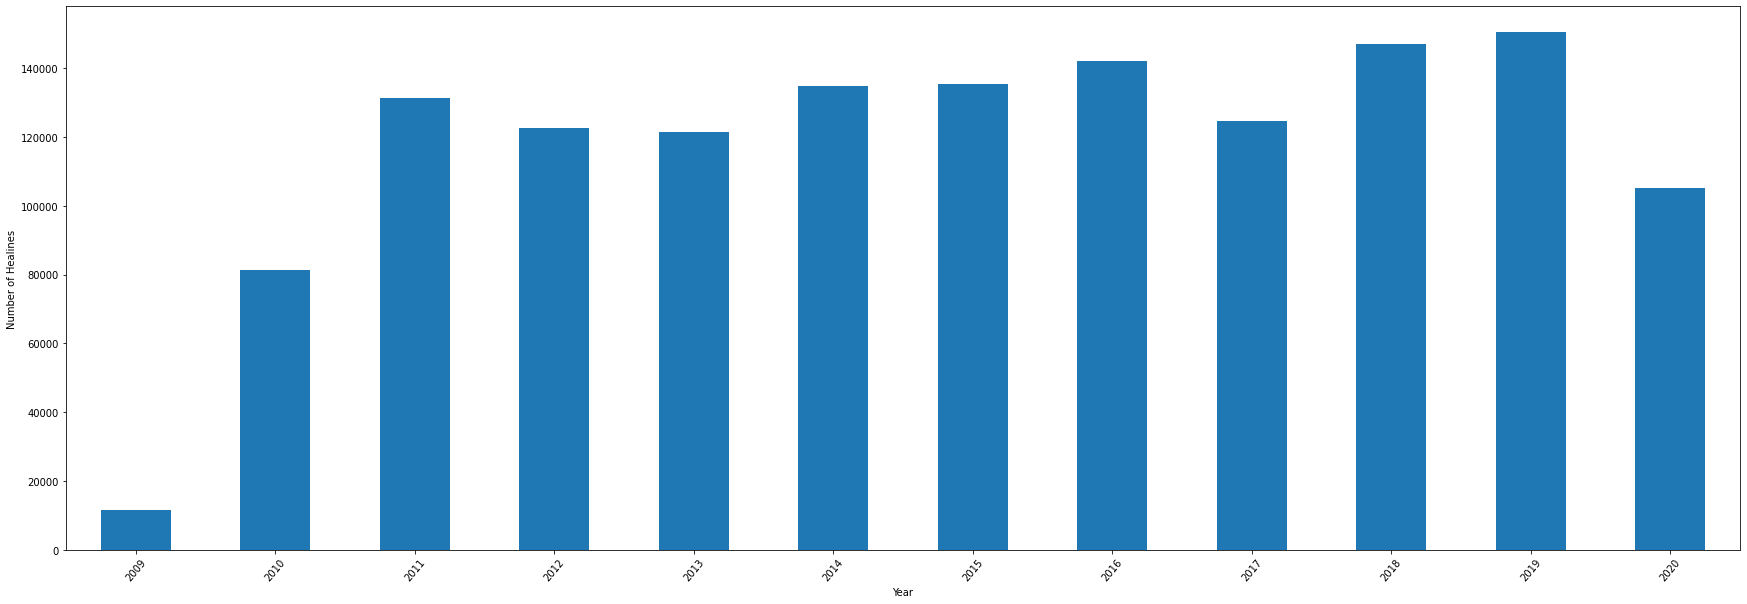

In [13]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [14]:
# Average Count of Headlines by Year
print('Durchschnittliche Anzahl an Aktiennews über die Jahr: ', statistics.mean(year.size()))

Durchschnittliche Anzahl an Aktiennews über die Jahr:  117277.33333333333


### Data Visualization

Verteilung und Menge

<AxesSubplot:>

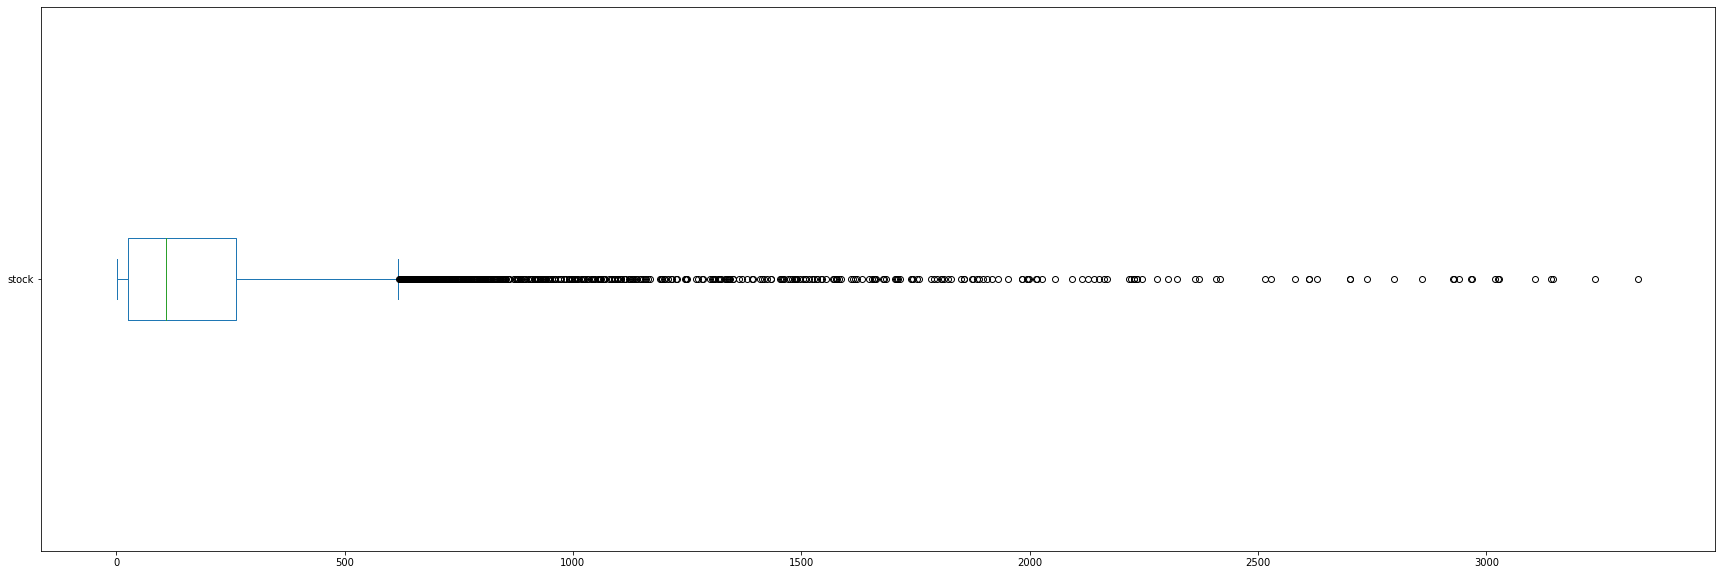

In [15]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

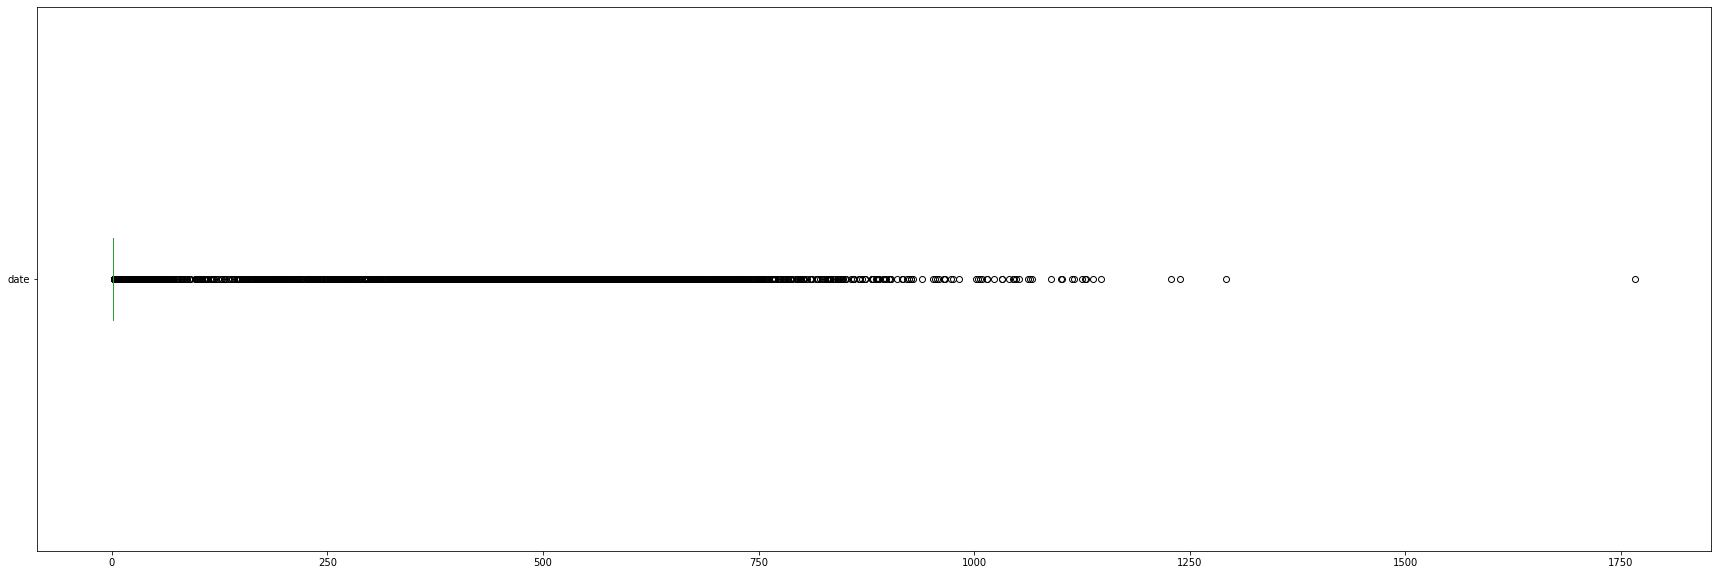

In [16]:
# BoxPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

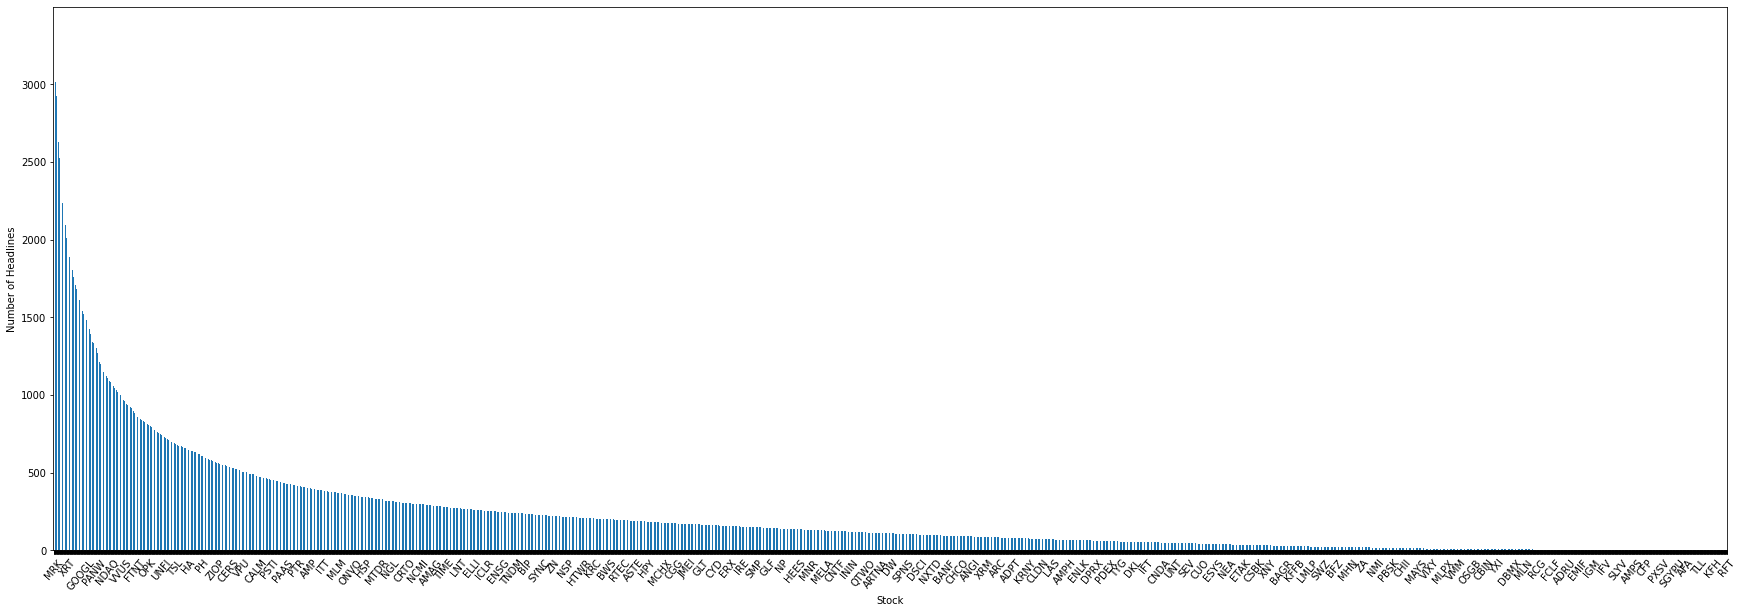

In [17]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

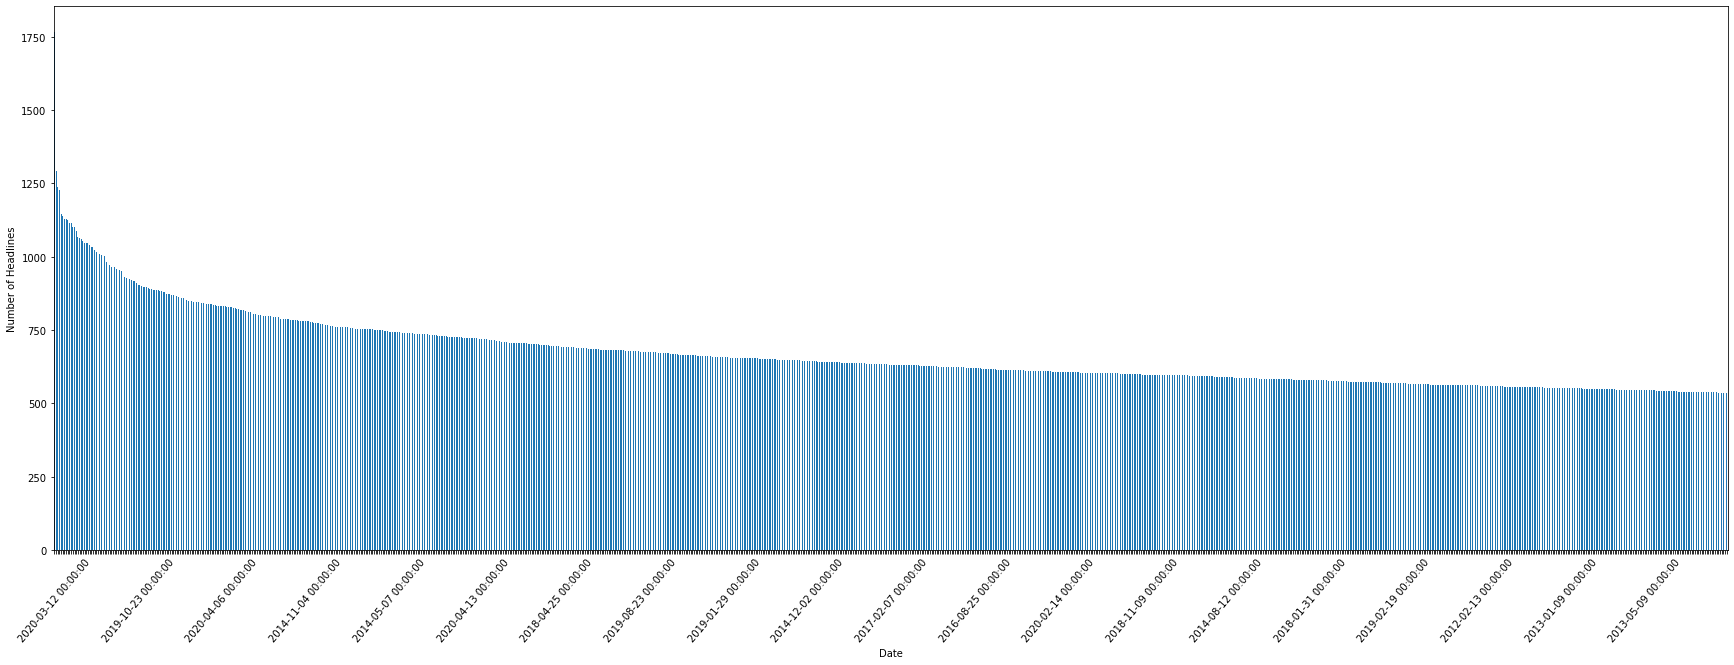

In [18]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordclouds

Ohne Bereinigung oder Stopword-Removal

WorldCloud over all Stocks, Top 50 Words:


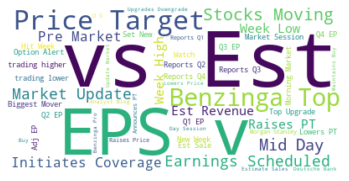

In [19]:
# Wordcloud for all Headlines together

# combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50

# wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud.png")

WorldCloud for Random Stock: FDML, Top 50 Words:


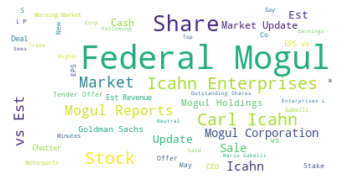

In [20]:
# Wordcloud for one random Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

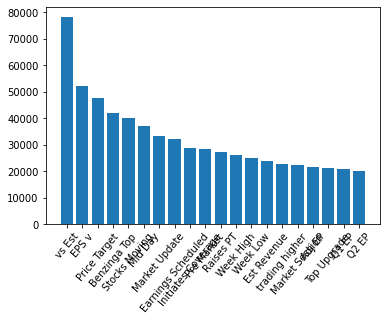

In [21]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

### Data Quality

In [22]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl von null Werten im gesamten DataFrame: 0
Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341
Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

In [23]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years, because of API and Performance
data = data.drop(data[data.date < '2019-08-21'].index)


In [24]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

In [25]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


#### Headline Cleaning & Pre-Processing
Hier wird nochmal speziell jede einzelene Headline den typischen pre-processing Schritten unterzogen

##### Define Headline Preprocessing
Requierements and def of Functions

In [26]:
# Part Of Speech Tagging suppling lemmatization

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result

In [27]:
# Stopword-removal
# Stopwords from NLTK Modul
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    # possible custom stopwords
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence

In [28]:
# WortNetLemmatizer Function for lemmatization
lemmatizer = WordNetLemmatizer()

# this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))
    # remove less than two char
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]
    # remove numeric
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]
    
    return lemmatized_output

In [29]:
# use most used synonym for the words, suppling Sentiments
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # remove word if no sentiment found
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [30]:
# calculate sentiment
senti_pos_score = []
senti_neg_score = []

senti_score = []

def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

##### Apply Headline Preprocessing

In [31]:
# headline as lowercase in a new colum
data['headline_cleaned'] = data['headline'].apply(lambda headline: headline.lower())

In [32]:
# tokenization und POS-Tagging
data['headline_cleaned'] = data['headline'].apply(tokenize_post)

In [33]:
# stopword-removal
data['headline_cleaned'] = data['headline_cleaned'].apply(remove_stopwords)

In [34]:
# lemmatization
data['headline_cleaned'] = data['headline_cleaned'].apply(lemmatize)

In [35]:
# replace by most used synonym
data['headline_cleaned'] = data['headline_cleaned'].apply(getSynset)

In [36]:
# calculate Sentiment
data['headline_cleaned'] = data['headline_cleaned'].apply(getSentiment)

# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score
data['senti_score'] = senti_score

In [37]:
#Export as csv for faster access
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

### Construct

#### API call to get StockPrices for all stocks
verwendete API : 'https://polygon.io/' <br>
(benötigt Timeouts zwischen den API calls da die API max 5 Api calls pro Minute bedient)

In [38]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [39]:
# API call with TimeOut (5 per minute)
def apiCall(stocks_unique):
    key = os.environ.get("POLYGON_IO_API_KEY") # API key in .env
    apiResults = []
    apiCount = 0
    for s in stocks_unique:
        # the API only response to 2years historical dates
        from_ = '2019-08-21'
        to =  '2020-12-31'

        # The API call
        with RESTClient(key) as client:
            resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
            # save the nessecary attributes of the JSON as List
            if (resp and hasattr(resp, 'results')):
                for result in resp.results:
                    dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                    apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
            # if there are no results to a specific stock add it any ways to the List, so later the quality of the DataFrame can be controlled 
            else: 
                apiResults.append([s])
                print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
        apiCount+=1
        print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
        time.sleep(12)
    return apiResults
# # # apiResults = apiCall(stocks_unique) ' Dont Run, because of Runtime and API-Key

# save the List-Data as DataFrame
# # # stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
# save the DataFrame as csv
# # # stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [40]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

##### Overview over the API Data

In [41]:
# count of the DataFrame
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [42]:
# First Look
print(stock_prices.columns)
stock_prices.sample(7)

Index(['stock', 'date', 'open', 'high', 'low', 'close'], dtype='object')


stock                 date     open      high      low     close
485974    GRC  2020-04-15T06:00:00   28.200   28.3500   26.620   26.7300
929782   REGN  2020-08-14T06:00:00  610.090  617.3100  610.090  612.5700
1094020  TREC  2019-10-28T05:00:00    8.750    8.8500    8.650    8.7200
790913   NSPR  2019-12-06T06:00:00    0.792    0.8280    0.774    0.7799
135623    BIT  2020-10-12T06:00:00   16.130   16.2700   16.130   16.2400
1227383  ZUMZ  2020-04-17T06:00:00   21.400   22.1075   20.540   21.6400
187808    CCI  2019-12-23T06:00:00  142.320  142.8300  140.380  140.5800

In [43]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 65


#### Combine DataFrame
füge den open und den close Preis der Aktie zur Headline am gleichen Tag hinzu

In [44]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [45]:
# format datetime to date as above for the data DataFrame
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

In [46]:
# remove headlines with date that are not covered by the stockprices -> probably Weekend
# datetime.datetime.fromisoformat().weekday() in [5,6]
data = data.drop(data[~data['date'].isin(stock_prices['date'])].index) # ~ means NOT IN
print('Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:\n', stock_prices.isna().sum())

Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:
 stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64


In [47]:
# Merge to the Final DataFrame
data = pd.merge(data, stock_prices[['stock', 'date', 'open', 'close']], on=['stock', 'date'])

#### Calculate Binary
##### Sentiment and Stockprice change
positive Sentiment = 1;
neutral Sentiment = 0;
negative Sentiment = -1

Stock Price Increase by more than x = 1;
Stock Price doesnt change more than x = 0;
Stock Price Decrease by more than x = -1

In [69]:
# calculate absolute values for the Stock Movement between [0,1]
def getQuotientStockPrice(row):
    return row['close']/row['open']

In [70]:
def getBinary(quotient):
    if quotient >= 1:
        return int(1)
    if quotient < 1:
        return int(0)

In [71]:
# calculate absolute values for the Sentiment between [-1,1]
def getBinarySenti(row):
    if row < 0:
        return 0
    if row >= 0:
        return 1

In [72]:
# add new colum with the "binary" Stockprice change
data["stockPrice_Quotient"] = data.apply(getQuotientStockPrice, axis=1)
data["stockPrice_Binary"] = data.stockPrice_Quotient.apply(getBinary)

In [73]:
# add new colum with the "binary" Sentiment
data['senti_Binary'] = data.senti_score.apply(getBinarySenti)

In [74]:
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Quotient', 'stockPrice_Binary',
       'senti_Binary'],
      dtype='object')


id                                           headline  \
92200    814436  Chop Chop: Strong Earnings Lift Markets After ...   
131220  1154406             Stocks That Hit 52-Week Lows On Friday   
87926    783624  Benzinga's Top Upgrades, Downgrades For Januar...   
121307  1067663  Shares of many financial companies are trading...   
132145  1162586  Shares of several drugmakers are trading lower...   
89658    791334  Benzinga's Top Upgrades, Downgrades For August...   
135051  1190448  Benzinga's Top Upgrades, Downgrades For June 4...   

              date stock                                   headline_cleaned  \
92200   2020-05-20   MDT  [chop.n.01, chop.n.01, strong.a.01, net_income...   
131220  2020-03-06  SMFG     [stocks.n.01, hit.v.01, low.n.01, friday.n.01]   
87926   2020-01-10  LRCX  [top.n.01, ascent.n.01, downgrade.n.01, januar...   
121307  2019-10-10   RBS  [share.n.01, many.a.01, fiscal.a.01, company.n...   
132145  2019-09-10   SNY  [share.n.01, several.s.01, trade.v.01, news.n....   
89658   2019-08-23     M  [top.n.01, ascent.n.01, downgrade.n.01, august...   
135051  2020-06-04  STNG  [top.n.01, ascent.n.01, downgrade.n.01, june.n...   

        senti_pos_score  senti_neg_score  senti_score    open   close  \
92200             0.500             0.00        0.500   97.89   98.08   
131220            0.000             0.00        0.000    5.91    5.89   
87926             0.000             0.00        0.000  299.11  294.34   
121307            1.375             0.75        0.625    4.71    4.94   
132145            0.000             0.75       -0.750   43.14   43.56   
89658             0.000             0.00        0.000   15.34   14.94   
135051            0.000             0.00        0.000   16.51   16.32   

        stockPrice_Quotient  stockPrice_Binary  senti_Binary  
92200              1.001941                  1             1  
131220             0.996616                  0             1  
87926              0.984053                  0             1  
121307             1.048832                  1             1  
132145             1.009736                  1             0  
89658              0.973924                  0             1  
135051             0.988492                  0             1

### Export The Final DataFrame

In [75]:
# export final DataSet as csv
data.to_csv('../data/analyst_ratings_processed_final.csv', index=False)

In [76]:
# import final DataSet for Modelling
# # # data = pd.read_csv('../data/analyst_ratings_processed_final.csv', converters={"headline_cleaned": lambda x: x.strip("[]").replace("'","").split(", ")})

### Overview

#### Final Look

In [77]:
# final Look
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7) #drop the colum just for the sample for better overview

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Quotient', 'stockPrice_Binary',
       'senti_Binary'],
      dtype='object')


id                                           headline  \
131981  1162415       Why Regeneron's Stock Is Trading Lower Today   
82321    728572  Shares of several financial services and globa...   
73605    641991  Horizon Therapeutics Shares Quiet Following Co...   
115962  1014255  Dave & Buster's Entertainment Cuts FY19 Sales ...   
8295      68409                      70 Biggest Movers From Friday   
1095       7583  Airlines Continue Suffering As Delta, American...   
73361    639165  Benzinga's Top Upgrades, Downgrades For Decemb...   

              date stock                                   headline_cleaned  \
131981  2020-04-27   SNY     [stock.n.01, trade.v.01, low.a.01, today.n.01]   
82321   2020-03-26   KKR  [share.n.01, several.s.01, fiscal.a.01, servic...   
73605   2020-03-31  HZNP  [horizon.n.01, therapeutics.n.01, share.n.01, ...   
115962  2019-09-10  PLAY  [fellow.n.06, entertainment.n.01, cut.n.01, gr...   
8295    2020-01-27  AMAG              [large.a.01, mover.n.01, friday.n.01]   
1095    2020-03-10  AAPL  [airline.n.01, agony.n.02, delta.n.01, america...   
73361   2019-12-09   HUN  [top.n.01, ascent.n.01, downgrade.n.01, decemb...   

        senti_pos_score  senti_neg_score  senti_score    open   close  \
131981            0.125            0.250       -0.125  51.020  50.630   
82321             0.500            1.250       -0.750  24.250  25.600   
73605             0.375            0.000        0.375  29.300  29.620   
115962            0.125            0.000        0.125  42.480  43.720   
8295              0.250            0.125        0.125   9.480   9.350   
1095              0.250            0.500       -0.250  69.285  71.335   
73361             0.000            0.000        0.000  23.310  23.320   

        stockPrice_Quotient  stockPrice_Binary  senti_Binary  
131981             0.992356                  0             0  
82321              1.055670                  1             0  
73605              1.010922                  1             1  
115962             1.029190                  1             1  
8295               0.986287                  0             1  
1095               1.029588                  1             0  
73361              1.000429                  1             1

In [78]:
# some statistics about the final DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 161478, features: 15 

unique headlines: 76162, unique stocks: 3722 



id                     161478
headline               161478
url                    161478
publisher              161478
date                   161478
stock                  161478
headline_cleaned       161478
senti_pos_score        161478
senti_neg_score        161478
senti_score            161478
open                   161478
close                  161478
stockPrice_Quotient    161478
stockPrice_Binary      161478
senti_Binary           161478
dtype: int64

#### Visialization
Verteilung und Menge

<AxesSubplot:>

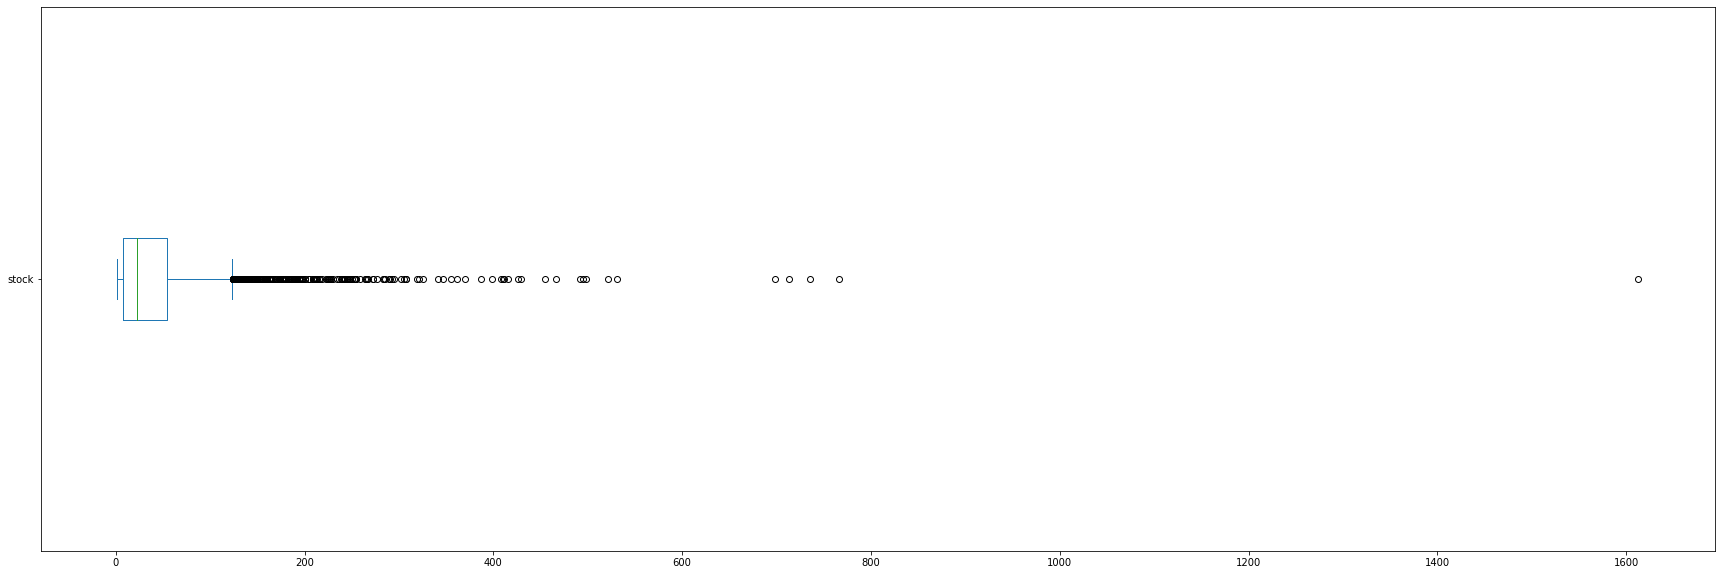

In [79]:
# BoxPlot of Stocks as above
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

In [80]:
stock = data.groupby("stock")

# Number of Headlines by Stock as above
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [81]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordcloud
Nach dem Bereinigen der Daten, inkl. Stopword Removal

WorldCloud over all Stocks, Top 50 Words:


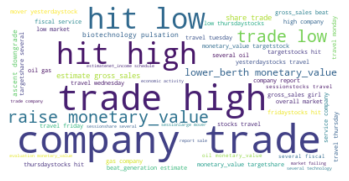

In [82]:
# Wordcloud for all Headlines

# combine all headlines to one text
text_afterCleaning = " "
for headline in data.headline_cleaned:
    text_afterCleaning = text_afterCleaning + ' '.join([word[:-5] for word in headline])

maxWords = 50
# wordcloud
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_afterCleaning)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud_afterCleaning.png")

In [83]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text_afterCleaning)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

## Modelling

### Simple Corellation
Überprüfe ob der Aktienpreis direkt mit dem Sentiment der Überschrift der Aktiennews zusammenhängt

positive correlation = 1 (sentiment == Positive -> stock price increase; sentiment == Negative -> stock price decrease); <br>
negative correlation = 0 (sentiment == Positive -> stock price decrease; sentiment == Negative -> stock price increase); <br>

In [84]:
data.describe().transpose()

count           mean            std       min  \
id                   161478.0  705046.579522  411428.843694  0.000000   
senti_pos_score      161478.0       0.230588       0.370747  0.000000   
senti_neg_score      161478.0       0.286830       0.512116  0.000000   
senti_score          161478.0      -0.056242       0.458934 -4.250000   
open                 161478.0      90.353547    2099.671264  0.050000   
close                161478.0      90.391451    2102.522520  0.079100   
stockPrice_Quotient  161478.0       0.999719       0.077222  0.124138   
stockPrice_Binary    161478.0       0.498681       0.500000  0.000000   
senti_Binary         161478.0       0.714407       0.451698  0.000000   

                               25%            50%           75%           max  
id                   340451.250000  707213.500000  1.065472e+06  1.412892e+06  
senti_pos_score           0.000000       0.125000  2.500000e-01  4.000000e+00  
senti_neg_score           0.000000       0.000000  2.500000e-01  4.250000e+00  
senti_score              -0.125000       0.000000  1.250000e-01  3.375000e+00  
open                     10.000000      32.240000  7.803000e+01  3.377540e+05  
close                     9.970000      32.180000  7.798750e+01  3.380801e+05  
stockPrice_Quotient       0.977477       0.999822  1.018396e+00  6.951904e+00  
stockPrice_Binary         0.000000       0.000000  1.000000e+00  1.000000e+00  
senti_Binary              0.000000       1.000000  1.000000e+00  1.000000e+00

In [85]:
correlation = pd.crosstab(data.senti_Binary, data.stockPrice_Binary, margins=True)
correlation

stockPrice_Binary      0      1     All
senti_Binary                           
0                  23619  22498   46117
1                  57333  58028  115361
All                80952  80526  161478

In [86]:
# calculate 'accuracy' of positive correlation
dataAbsoluteCount = data.shape[0]
print("Von " + str(dataAbsoluteCount) + " Headlines mit Sentiment-Score korrelieren " + str((correlation.loc[0].loc[0]+correlation.loc[1].loc[1])) +" positiv mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str((correlation.loc[0].loc[0]+correlation.loc[1].loc[1])/dataAbsoluteCount))
print("Von " + str(dataAbsoluteCount) + " Headlines mit Sentiment-Score korrelieren " + str((correlation.loc[0].loc[1]+correlation.loc[1].loc[0])) +" negativ mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str((correlation.loc[0].loc[1]+correlation.loc[1].loc[0])/dataAbsoluteCount))

Von 161478 Headlines mit Sentiment-Score korrelieren 81647 positiv mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.5056230570108622
Von 161478 Headlines mit Sentiment-Score korrelieren 79831 negativ mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.4943769429891378


### Linear Regression based on the Sentimentscore

Im folgenden werden ein paar Lineare-Regressionsmodelle aufgebaut und mit einander Verglichen. <br>
Die Regressionsmodelle unterscheiden sich dabei in den Predictoren, welche alle sam taus dem Datensatz entnommen werden.

In [87]:
# calculate the count of publications to the stock on the day of publication
# is used later, but needed aalready here for the train_test_split
# incl Progressbar
countTimer = 1
def calPublishCount(row):
    global countTimer
    count = data[(data['stock'] == row['stock']) & (data['date'] == row['date'])]['id'].count()

    #print Progress
    progress = (countTimer/161478)*100
    #sys.stdout.write("\r[ %s ]%d%%" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress))
    sys.stdout.write("\r[ %s ]%d%% ::: %d out of %d, id: %d: %d" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress, countTimer, 161478, row['id'], count))
    sys.stdout.flush()
    countTimer += 1

    return count

In [88]:
# add the count of publications to the stock on the day as news colum
# is used later, but needed aalready here for the train_test_split
data['publish_count'] = data.apply(calPublishCount, axis=1) # Dont Run because of Runtime
# export the extended DataFrame
data.to_csv('../data/analyst_ratings_processed_final_count.csv', index=False)

[ #################################################################################################### ]100% ::: 161478 out of 161478, id: 1412892: 1

In [113]:
# import the extended DataFrame
# # # data = pd.read_csv('../data/analyst_ratings_processed_final_count.csv', converters={"headline_cleaned": lambda x: x.strip("[]").replace("'","").split(", ")})
#!!! repeat the test_train_split here!!!!

In [114]:
# Split the DataFrame in Train and Test Data
splitted_set = train_test_split(data, test_size=0.3)
train_set = splitted_set[0]
test_set = splitted_set[1]

In [115]:
# Targetvariable
Y = train_set['stockPrice_Quotient']
Y = np.array(list(Y))

#### simple Regression by senti_score

In [116]:
# only use the senti_score as Predictor on the train_set
X_sentiScore = train_set['senti_score'] 
# need 2D Array
X_sentiScore = np.array(list(X_sentiScore)).reshape((-1, 1))

In [117]:
# Model just with senti_score
model_sentiScore = LinearRegression().fit(X_sentiScore,Y)

In [118]:
# apply the prediction to the test_set
test_set["prediction_sentiScore"] = test_set.apply(lambda row: model_sentiScore.predict([[row['senti_score']]])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/2812329693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiScore"] = test_set.apply(lambda row: model_sentiScore.predict([[row['senti_score']]])[0], axis=1)


In [119]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiScore"] = test_set["prediction_sentiScore"].apply(getBinary)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/436190870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiScore"] = test_set["prediction_sentiScore"].apply(getBinary)


#### simple Regression by senti_pos_score and senti_neg_score

In [120]:
# senti_score as Positive and negative as Predictor on the train_set
X_sentiPosNeg = train_set[['senti_pos_score', 'senti_neg_score']].values.tolist()

In [121]:
# Model with pos and neg senti
model_sentiPosNeg = LinearRegression().fit(X_sentiPosNeg,Y)

In [122]:
# apply the prediction to the test_set
test_set["prediction_sentiPosNeg"] = test_set.apply(lambda row: model_sentiPosNeg.predict([row[['senti_pos_score', 'senti_neg_score']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/3672045541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiPosNeg"] = test_set.apply(lambda row: model_sentiPosNeg.predict([row[['senti_pos_score', 'senti_neg_score']].values.tolist()])[0], axis=1)


In [123]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiPosNeg"] = test_set["prediction_sentiPosNeg"].apply(getBinary)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/3147860814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiPosNeg"] = test_set["prediction_sentiPosNeg"].apply(getBinary)


#### simple Regression by senti_pos_score and senti_neg_score and open

In [124]:
# pos and neg senti_score and the open Price as Predictor on the train_set
X_wOpen = train_set[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()

In [125]:
# Model with pos and neg senti
model_wOpen = LinearRegression().fit(X_wOpen,Y)

In [126]:
# apply the prediction to the test_set
test_set["prediction_wOpen"] = test_set.apply(lambda row: model_wOpen.predict([row[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/1718047201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wOpen"] = test_set.apply(lambda row: model_wOpen.predict([row[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()])[0], axis=1)


In [127]:
# standartization of the preditcitons in the test_set
test_set["prediction_wOpen"] = test_set["prediction_wOpen"].apply(getBinary)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/3789541949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wOpen"] = test_set["prediction_wOpen"].apply(getBinary)


#### simple Regression by senti_pos_score and senti_neg_score and count of Publication

In [128]:
# pos and neg senti_score and publish_count as Predictor on the train_set
X_wPublishCount = train_set[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()

In [129]:
# Model with pos and neg senti as also the count of publications to the stock on the day
model_wPublishCount = LinearRegression().fit(X_wPublishCount,Y)

In [130]:
# apply the prediction to the test_set
test_set["prediction_wPublishCount"] = test_set.apply(lambda row: model_wPublishCount.predict([row[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/1145951997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wPublishCount"] = test_set.apply(lambda row: model_wPublishCount.predict([row[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()])[0], axis=1)


In [131]:
# standartization of the preditcitons in the test_set
test_set["prediction_wPublishCount"] = test_set["prediction_wPublishCount"].apply(getBinary)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/3505114055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wPublishCount"] = test_set["prediction_wPublishCount"].apply(getBinary)


#### Evaluation

In [132]:
ModelEvaluationRow = ['senti_score', 'senti_pos_score,\nsenti_neg_score', 'with open', 'with PublishCount']
ModelEvaluationCol = ['intercept', 'coefficients', 'R^2', 'accuracy', 'rmse']

ModelEvaluation_sentiScore = [model_sentiScore.intercept_, model_sentiScore.coef_, model_sentiScore.score(X_sentiScore, Y), test_set[test_set['prediction_sentiScore'] == test_set['stockPrice_Binary']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Binary']), list(test_set['prediction_sentiScore']), squared=False)]
ModelEvaluation_sentiPosNeg = [model_sentiPosNeg.intercept_, model_sentiPosNeg.coef_, model_sentiPosNeg.score(X_sentiPosNeg, Y), test_set[test_set['prediction_sentiPosNeg'] == test_set['stockPrice_Binary']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Binary']), list(test_set['prediction_sentiPosNeg']), squared=False)]

ModelEvaluation_wOpen = [model_wOpen.intercept_, model_wOpen.coef_, model_wOpen.score(X_wOpen, Y), test_set[test_set['prediction_wOpen'] == test_set['stockPrice_Binary']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Binary']), list(test_set['prediction_wOpen']), squared=False)]
ModelEvaluation_wPublishCount = [model_wPublishCount.intercept_, model_wPublishCount.coef_, model_wPublishCount.score(X_wPublishCount, Y), test_set[test_set['prediction_wPublishCount'] == test_set['stockPrice_Binary']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Binary']), list(test_set['prediction_wPublishCount']), squared=False)]

ModelEvaluation = [ModelEvaluation_sentiScore, ModelEvaluation_sentiPosNeg, ModelEvaluation_wOpen, ModelEvaluation_wPublishCount]

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


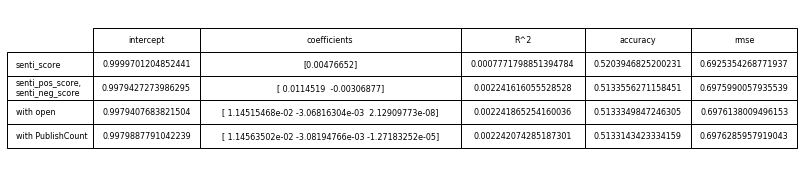

In [133]:
fig, ax = plt.subplots(figsize=(6,3))

# Hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.patch.set_linewidth('0.1')

table = ax.table(ModelEvaluation, colLabels=ModelEvaluationCol, rowLabels=ModelEvaluationRow, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1,2)
table.auto_set_column_width(col=list(range(len(ModelEvaluationCol))))

plt.show()
#plt.savefig('./results/evaluation_sentiment_Modelling.png')

In [134]:
print('senti_score:\n', pd.crosstab(test_set.prediction_sentiScore, test_set.stockPrice_Binary, margins=True))
print('sentiPosNeg:\n', pd.crosstab(test_set.prediction_sentiPosNeg, test_set.stockPrice_Binary, margins=True))
print('wOpen:\n', pd.crosstab(test_set.prediction_wOpen, test_set.stockPrice_Binary, margins=True))
print('wPublishCount:\n', pd.crosstab(test_set.prediction_wPublishCount, test_set.stockPrice_Binary, margins=True))

senti_score:
 stockPrice_Binary          0      1    All
prediction_sentiScore                     
0                      16564  15669  32233
1                       7565   8646  16211
All                    24129  24315  48444
sentiPosNeg:
 stockPrice_Binary           0      1    All
prediction_sentiPosNeg                     
0                       17205  16651  33856
1                        6924   7664  14588
All                     24129  24315  48444
wOpen:
 stockPrice_Binary      0      1    All
prediction_wOpen                      
0                  17204  16651  33855
1                   6925   7664  14589
All                24129  24315  48444
wPublishCount:
 stockPrice_Binary             0      1    All
prediction_wPublishCount                     
0                         17229  16677  33906
1                          6900   7638  14538
All                       24129  24315  48444


#### Export Linear Regression Sentiment Model

In [137]:
import joblib
joblib.dump(model_sentiPosNeg, './deployment/sentiment_model.pkl')

['./deployment/sentiment_model.pkl']

### TF-IDF

#### Preparation of the DataSet

In [138]:
# subset of the DataFrame without some column (without any impact, just for overview)
data = data[['id','headline', 'stock', 'headline_cleaned','open','close', 'stockPrice_Binary', 'stockPrice_Quotient']]
# rename for identification after adding of TermMatrix (some columlabel might be in the headlines)
data = data.rename(columns={'headline': '_headline', 'headline_cleaned':'_headline_cleaned', 'stock': '_stock', 'open': '_open', 'close':'_close', 'stockPrice_Binary':'_stockPrice_Binary', 'stockPrice_Quotient':'_stockPrice_Quotient'})

In [139]:
# set index for Merge 
data = data.set_index('id')

In [140]:
# POS tagged and tokenzized Array to String
def tokenz_in_sentence(hl):
    word_list = [word[:-5] for word in hl]
    sentence = ' '.join(word_list)
    return sentence

In [141]:
# apply new column with preProcessed headlines as sentences
data['_headline_sentence'] = data._headline_cleaned.apply(tokenz_in_sentence)
# as list
data_headlines = data['_headline_sentence'].tolist()

#### Term Frequency - Inverse Document Frequency

In [142]:
# Matrix of Token Counts
count_vectorizer = CountVectorizer(analyzer="word", stop_words="english")
# Matrix of Features
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', smooth_idf=True, use_idf=True)

In [143]:
#!! some Allocation Error, Good Luck
# apply matrix to the headlines
count_wm = count_vectorizer.fit_transform(data_headlines)
tfidf_wm = tfidf_vectorizer.fit_transform(data_headlines)
# get columns
count_tokenz = count_vectorizer.get_feature_names()
tfidf_tokenz = tfidf_vectorizer.get_feature_names()
# Make as DataFrame to Merge
df_countvect = pd.DataFrame(data=count_wm.toarray(), index=data.index, columns=count_tokenz)
df_tfidfvect = pd.DataFrame(data= tfidf_wm.toarray(), index=data.index, columns=tfidf_tokenz)

In [144]:
# export the Matrixes because of some Allocation error sometimes #960sec
# # # df_countvect.to_csv('../data/df_countvect.csv', index=False)
# # # df_tfidfvect.to_csv('../data/df_tfidfvect.csv', index=False)

In [145]:
# # # df_countvect = pd.read_csv('../data/df_countvect.csv')
# # # df_tfidfvect = pd.read_csv('../data/df_tfidfvect.csv')

In [146]:
cols_to_delete = []
for column in df_tfidfvect:
    count = df_tfidfvect[df_tfidfvect[column] > 0].shape[0]
    if count<10:
        cols_to_delete.append(column)

print('Anzahl zu löschender Spalten (geringeres Vorkommen als 20) ',len(cols_to_delete))
print('Anzahl der Gesamt Spalten', df_tfidfvect.shape[1])

Anzahl zu löschender Spalten (geringeres Vorkommen als 20)  5322
Anzahl der Gesamt Spalten 8931


In [147]:
# delete the Column that appier less than 20 times
df_tfidfvect.drop(axis=1, columns=cols_to_delete, inplace=True)

In [148]:
#!! some Allocation Error, Good Luck 
# Merge the Headline-StockPrice-DataFrame with the TF_IDF-Matrix
data_with_tfidf = data.merge(df_tfidfvect, on='id')

##### Export der tfidf Matrix mit dem Datensatz, aufgrund von einigen Memory-Allocation-Error

In [149]:
# export final DataSet as csv
data_with_tfidf.to_csv('../data/analyst_ratings_processed_final_tfidf_merged.csv')

In [150]:
# import final DataSet for Modelling
# # # data_with_tfidf = pd.read_csv('../data/analyst_ratings_processed_final_tfidf_merged.csv' converters={"_headline_cleaned": lambda x: x.strip("[]").replace("'","").split(", ")})

#### Hyperparameter Tuning

In [151]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [30, 37, 45, 53, 61, 68, 76, 84, 92, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [152]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2)

In [153]:
# Fit the random search model
# rf_random.fit(X, y)

In [154]:
# rf_random.best_params_

#### Random Forest

In [155]:
splitted_set = train_test_split(data_with_tfidf, test_size=0.3)
train_set = splitted_set[0]
test_set = splitted_set[1]

In [156]:
X = train_set.drop(columns=['_headline', '_stock', '_headline_cleaned', '_open', '_close', '_stockPrice_Quotient', '_stockPrice_Binary', '_headline_sentence'])
Y = train_set['_stockPrice_Quotient']

In [157]:
# export the feature list for deployment
feature_words = list(X)
dflist = pd.DataFrame(feature_words)
dflist.to_csv('../data/tfidf_features.csv', index=False)

In [158]:
# Regressor with Parameters from Hypertuning
regressor = RandomForestRegressor( n_estimators=37, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=10, bootstrap=True)
# Training of the Model on the Train set
regressor.fit(X, Y)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=37)

In [159]:
# test_set = test_set.drop(columns=['_headline', '_stock', '_headline_cleaned', '_open', '_close', '_stockPrice_Quotient', '_stockPrice_Binary', '_headline_sentence'])
test_set["_prediction"] = test_set.apply(lambda row: regressor.predict([row[8:]]), axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/2104166505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["_prediction"] = test_set.apply(lambda row: regressor.predict([row[8:]]), axis=1)


In [160]:
test_set['_prediction'] = test_set._prediction.apply(getBinary)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_7056/3555951001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['_prediction'] = test_set._prediction.apply(getBinary)


#### Evaluation

In [161]:
# make one Prediction
def predictHeadline(hl):

    count_hl = len(list(hl.split()))
    single_headline_tfidf = pd.DataFrame()
    feature_list = list(pd.read_csv('./deployment/app/tfidf_features.csv')['0'])
    for feature in feature_list:
        idf_value = tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[feature]]
        count_feature = hl.count(feature)
        single_headline_tfidf[feature] = [(count_feature / count_hl) * idf_value]
    print(regressor.predict(single_headline_tfidf))
    
# predictHeadline("stock very high best apple low")


In [162]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_set['_stockPrice_Binary'], test_set['_prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(test_set['_stockPrice_Binary'], test_set['_prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_set['_stockPrice_Binary'], test_set['_prediction'])))

Mean Absolute Error: 0.4342952687639336
Mean Squared Error: 0.4342952687639336
Root Mean Squared Error: 0.6590108259838632


In [163]:
print('Accuracy Score:', metrics.accuracy_score(test_set['_stockPrice_Binary'], test_set['_prediction']))

Accuracy Score: 0.5657047312360663


#### Export TF-IDF RandomForest

In [164]:
import joblib
joblib.dump(regressor, './deployment/tfidf_model.pkl')
joblib.dump(tfidf_vectorizer, './deployment/tfidf_vectorizer.pkl')

['./deployment/tfidf_vectorizer.pkl']